In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('..')
from selex_dca import *

import pickle
import glob
from math import ceil, sqrt, floor
import random

/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File names for data

In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))
ts = range(len(round_ids))

In [3]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [ ]:
sequences_all = [[sequences_from_file(experiment_id, round_id, device) 
                  for round_id in round_ids] for experiment_id in experiment_ids];

## Extract sequences and compute 1st and 2nd moment statistics, write to files

In [8]:
pseudocounts = np.linspace(0, 1, 21)

In [18]:
for n in range(len(sequences_all)):   
    experiment_id = experiment_ids[n]
    sequences_oh_all = [one_hot(seq, num_classes=4).to(dtype) for seq in sequences_all[n]]
    for pseudocount in pseudocounts:
        freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
            *[frequences_from_sequences_oh(seq, pseudo_count=pseudocount, dtype=dtype) for seq in sequences_oh_all[n]])
        fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
        fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
        total_reads = torch.tensor(total_reads_tuple)
    
        pc_str = format(pseudocount, '.2f')
        
        filename = experiment_id + "freq_pseudocount" + pc_str + ".pkl"
        filepath = "saved/freq_pseudocount/" + filename
        
        data = [fi, fij, total_reads]
        
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

In [11]:
wts_sites = []

for n in range(len(sequences_all)):   
    experiment_id = experiment_ids[n]
    freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
        *[frequences_from_sequences(seq, pseudo_count=0, dtype=dtype) for seq in sequences_all[n]])
    wt = guess_wildtype_from_site_counts(freq_single_tuple[0])
    print(experiment_id)
    wts_sites.append(wt)

Dop8V030
Dop8V930
Dop8V2430


In [17]:
filepath = 'saved/wildtypes_sites.pkl'
with open(filepath, 'wb') as f:
    pickle.dump(wts_sites, f)

In [136]:
ls = np.linspace(0, 1, 21)
ls_s = [format(x, '.2f') for x in ls]
' '.join(ls_s)

'0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95 1.00'

# Read

## Read parameters of trained models from all three datasets

In [6]:
data = []

for n in ns:
    data.append([])
    for filepath in sorted(glob.iglob('./saved/pseudocount/'+experiment_ids[n]+'*.pkl')):
        with open(filepath, 'rb') as f:
            data[-1].append(pickle.load(f))
    print(f"Dataset f{experiment_ids[n]}. Loaded {len(data[-1])} files.")

experiment_id_all, round_ids_all, params_all, pseudocount_all, pearson_final_all = zip(*[
    zip(*d) for d in data])

for n in ns:
    assert((sorted(np.array(pseudocount_all[n])) == np.array(pseudocount_all[n])).all())
    assert((np.array(pearson_final_all[n]) > 0.9).all())
    assert((np.array(experiment_id_all[n]) == experiment_ids[n]).all())

Dataset fDop8V030. Loaded 20 files.
Dataset fDop8V930. Loaded 20 files.
Dataset fDop8V2430. Loaded 20 files.


In [21]:
filepath = './saved/wildtypes_sites.pkl'
with open(filepath, 'rb') as f:
    wts = pickle.load(f)

wts_oh = [adabmDCA.functional.one_hot(wts[n][None,:]) for n in ns]

In [9]:
pc_idx = range(len(pseudocount_all[0]))

In [7]:
sequences_unique_all, inverse_indices_all, counts_all = zip(*[zip(*[
    torch.unique(seq_t, dim=0, return_inverse=True, return_counts=True)
    for seq_t in sequences_all[n]]) for n in ns])
sequences_unique_oh_all = [[one_hot(s) for s in sequences_unique_all[n]] for n in ns]

In [10]:
params_t_all = [[[get_params_at_round(params_all[n][a], t) for t in ts] for a in pc_idx] for n in ns]

In [90]:
logNst_all = [[[-adabmDCA.statmech.compute_energy(
            sequences_unique_oh_all[n][t], params_t_all[n][a][t])
               for t in ts] for a in pc_idx] for n in ns]

In [97]:
logNst_thresh = -200

X, Y = zip(*[zip(*[zip(*[vectors_for_scatterplot_single_t_unique(logNst_all[n][a][t], counts_all[n][t], 
                                                                 logNst_thresh, inverse_indices_all[n][t])
                  for t in ts]) for a in pc_idx]) for n in ns])

Predicted logNst vs log-counts at different values of pseudocount

Dataset Dop8V930


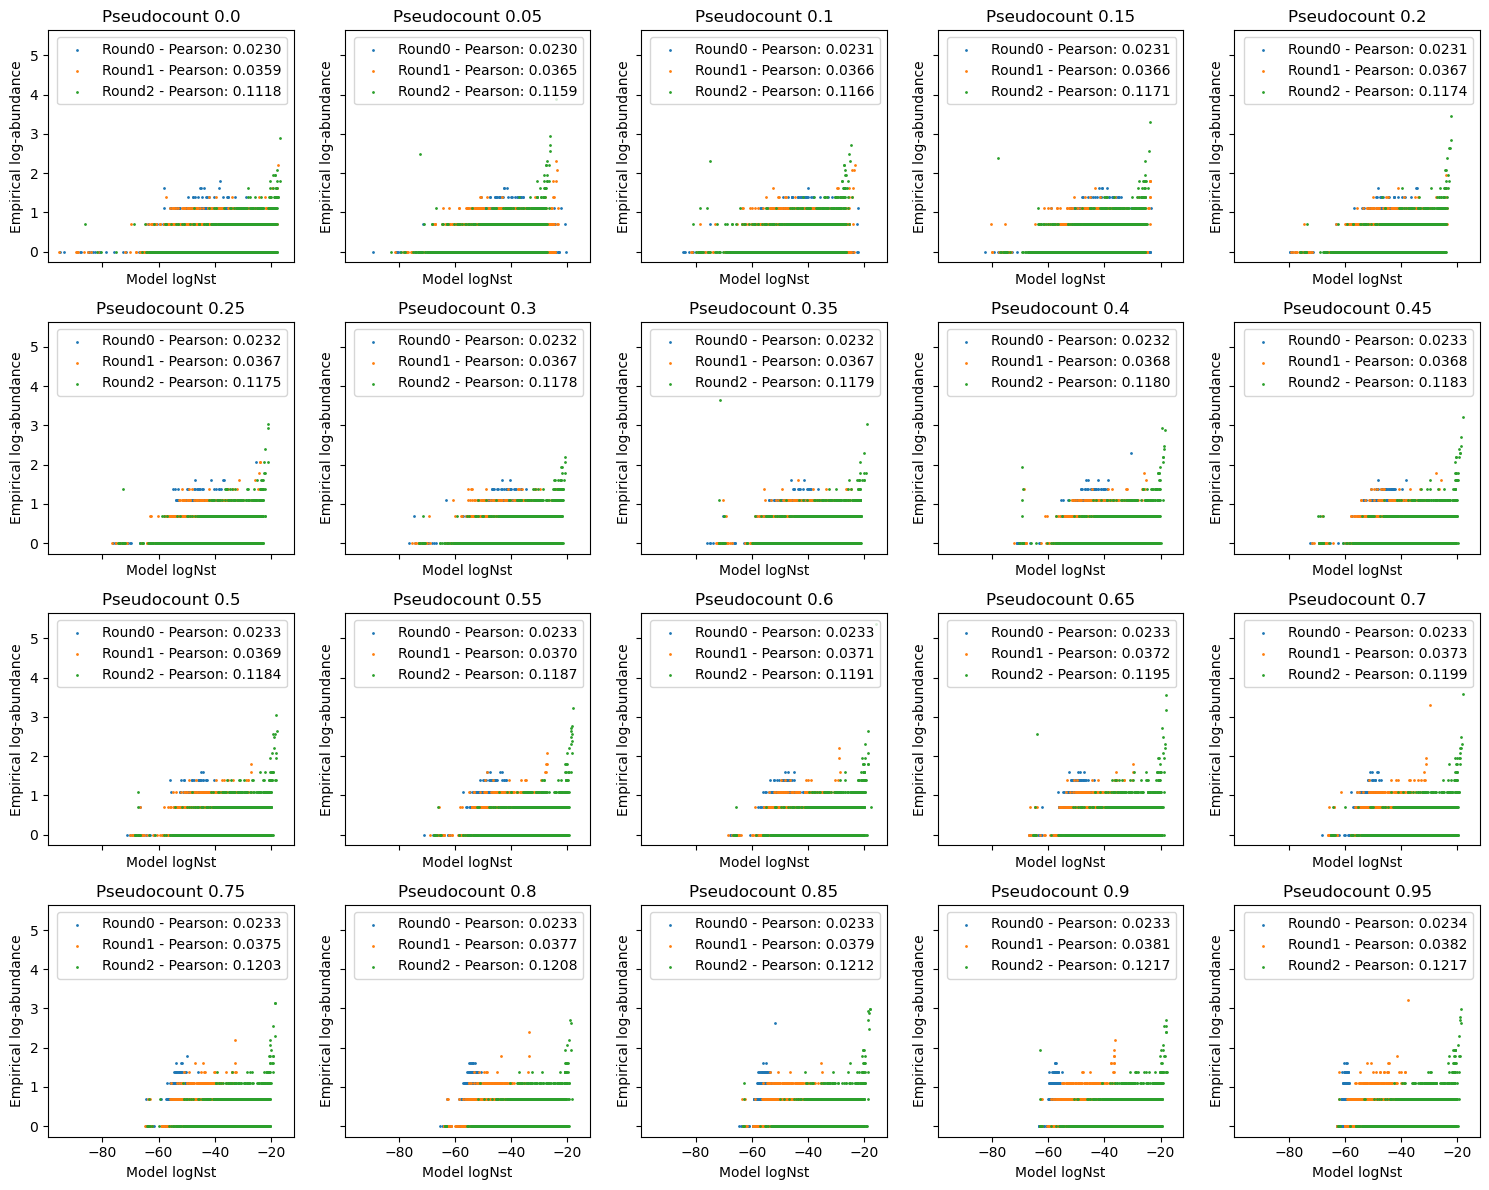

In [102]:
n = 1
print(f"Dataset {experiment_ids[n]}")

N = 10**4
l = ceil(sqrt(len(pseudocount_all[0])))
pl, axes = plt.subplots(l-1, l, figsize=(3*l,3*(l-1)), sharex=True, sharey=True)

for a in pc_idx:
    row    = floor(a / l)
    column = a % l
    ax = axes[row, column]
    for t in ts:
        x = X[n][a][t]; y = Y[n][a][t]
        pearson = torch.corrcoef(torch.stack((x, y)))[0,1]
        idx = random.sample(range(len(x)),min(N, len(x)))
        ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson:.{4}f}", s=1)
        ax.set_xlabel("Model logNst")
        ax.set_ylabel("Empirical log-abundance")
        ax.set_title(f"Pseudocount {pseudocount_all[n][a]}")
    ax.legend()
plt.tight_layout()

# Cross-dataset predictions

## logNst

In [110]:
logNst_cross = [[[[-adabmDCA.statmech.compute_energy(
    sequences_unique_oh_all[m][t], params_t_all[n][a][t]) 
              for t in ts] for a in pc_idx] for n in ns] for m in ns]

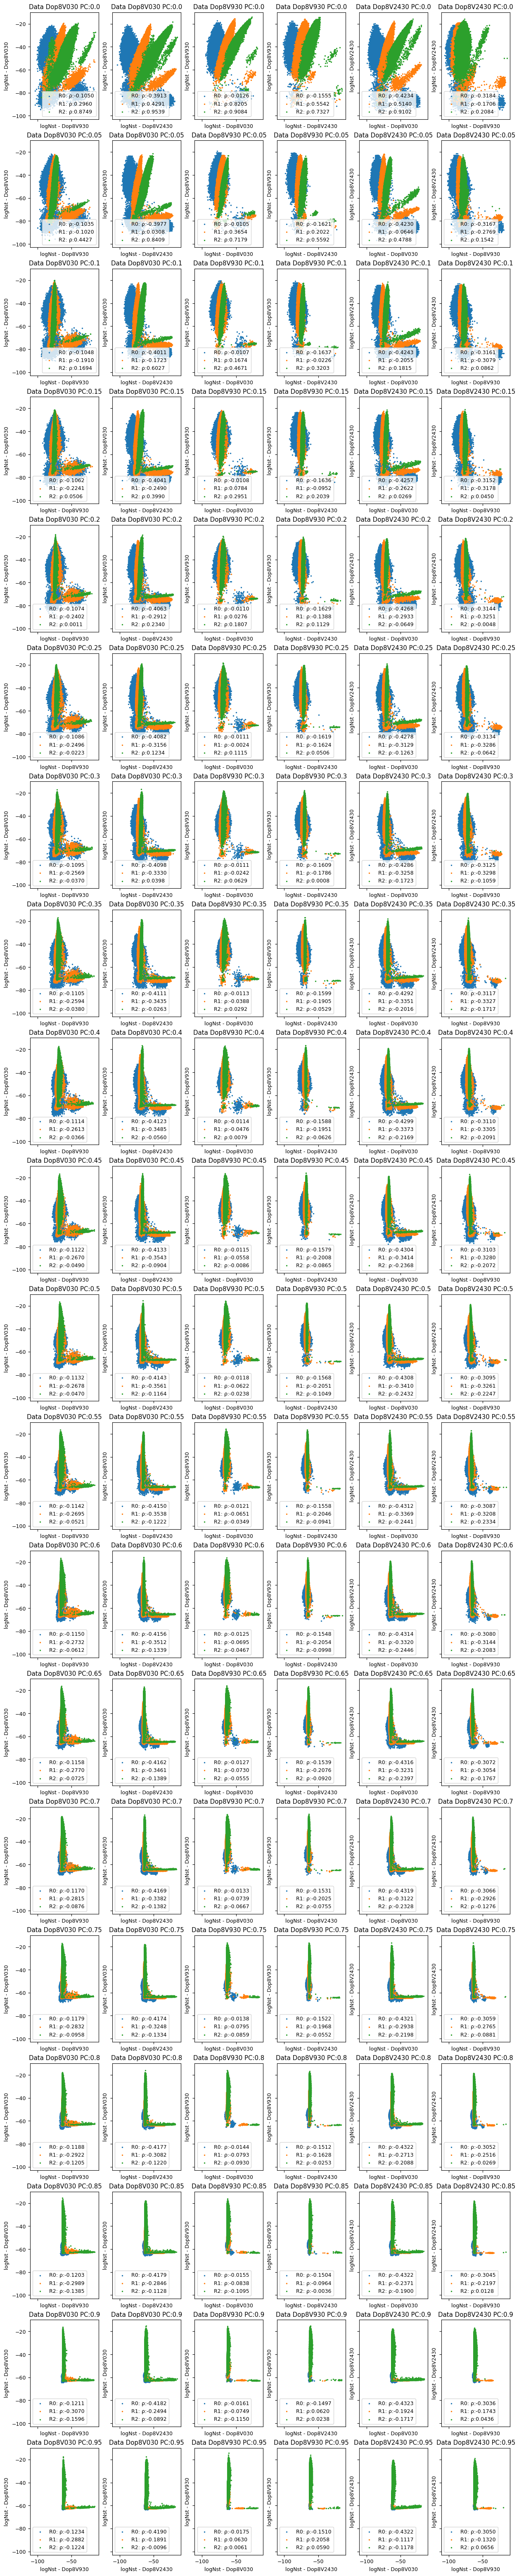

In [122]:
N = 10**5

fig, axes = plt.subplots(len(pc_idx), 6, figsize=(15,3*len(pc_idx)), sharex=True, sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=9) 

for a in pc_idx:
    j = -1
    for m in ns:
        for n in ns:
            if m != n:
                j += 1
                ax = axes[a,j]
                for t in ts:
                    x = logNst_cross[m][n][a][t]
                    y = logNst_cross[m][m][a][t]
                    pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
                    idx = random.sample(range(len(x)),min(N, len(x)))
                    ax.scatter(x[idx], y[idx], label=f"R{t}: ρ:{pearson:.{4}f}", s=2, color=colors[t])
                    ax.set_xlabel(f"logNst - {experiment_ids[n]}")
                    ax.set_ylabel(f"logNst - {experiment_ids[m]}")
                    ax.set_title(f"Data {experiment_ids[m]} PC:{pseudocount_all[n][a]}")
                # for t in ts:
                #     ax.scatter(logNst_wildtype_x[a][i][t], logNst_wildtype_y[a][i][t], marker='s', label=f"wt Round {t}", s=20, 
                #                color=colors[t], edgecolor='black')
                # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                ax.legend()
    # plt.tight_layout()
plt.savefig('img/logNst_cross_pseudocount.png')

## log ps

In [11]:
params_ps_all = [[get_params_ps(params_all[n][a]) for a in pc_idx] for n in ns]

In [12]:
logps_cross = [[[[-adabmDCA.statmech.compute_energy(
    sequences_unique_oh_all[m][t], params_ps_all[n][a]) 
              for t in ts] for a in pc_idx] for n in ns] for m in ns]

In [25]:
logps_wt_cross = [[[-adabmDCA.statmech.compute_energy(wts_oh[m], params_ps_all[n][a]) 
                    for a in pc_idx] for n in ns] for m in ns]

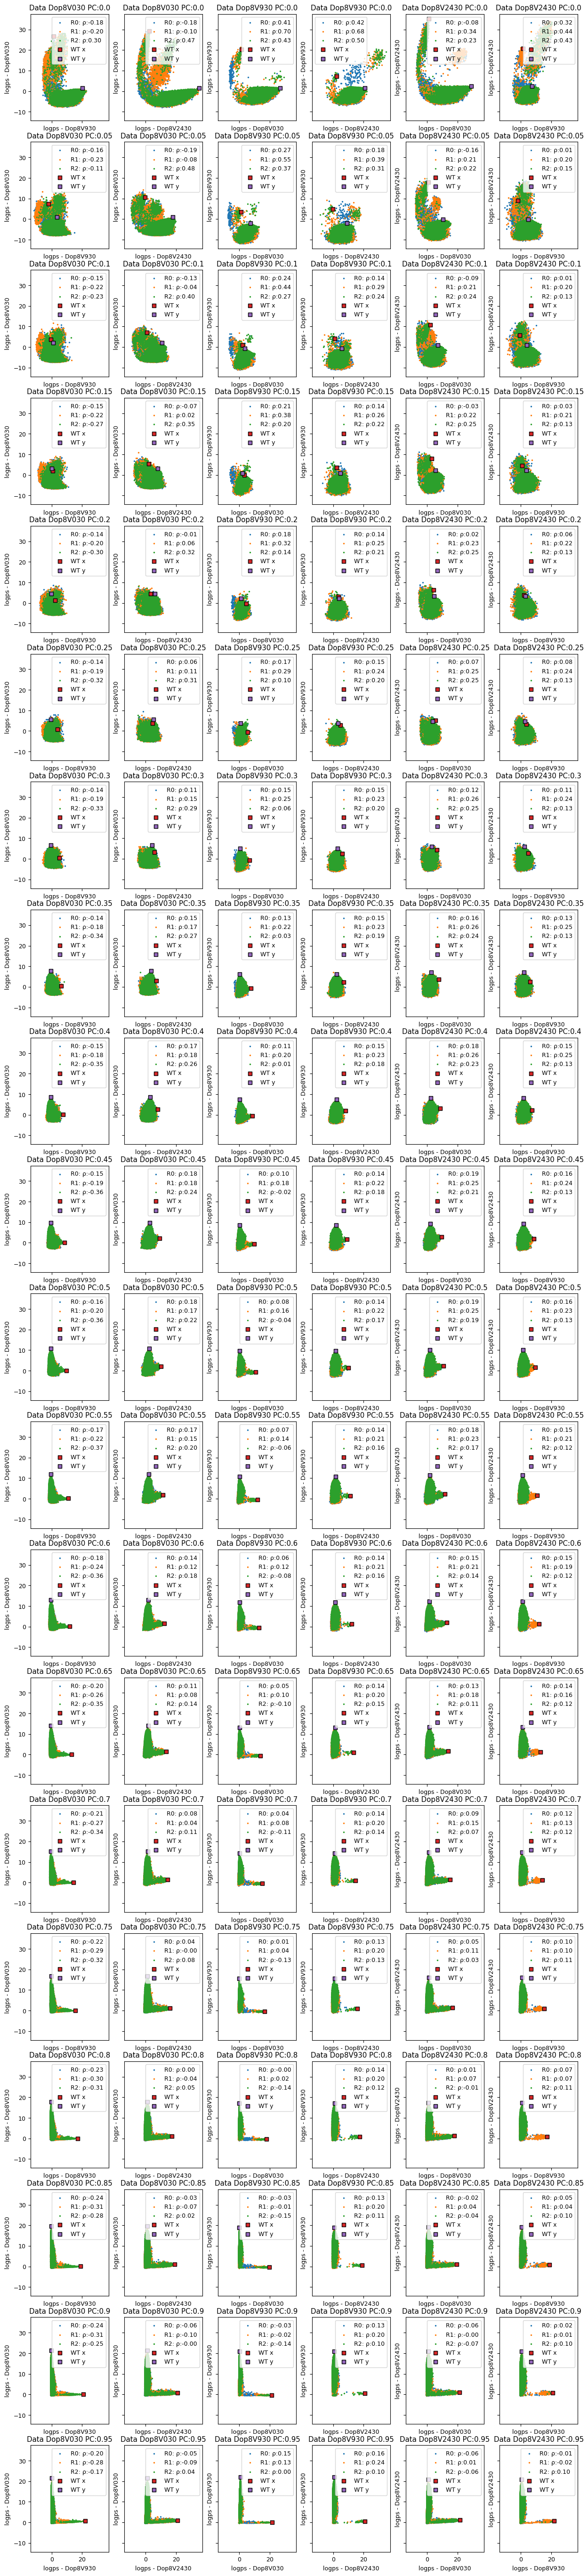

In [31]:
N = 10**5

fig, axes = plt.subplots(len(pc_idx), 6, figsize=(15,3.5*len(pc_idx)), sharex=True, sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=9) 

for a in pc_idx:
    j = -1
    for m in ns:
        for n in ns:
            if m != n:
                j += 1
                ax = axes[a,j]
                for t in ts:
                    x = logps_cross[m][n][a][t]
                    y = logps_cross[m][m][a][t]
                    pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
                    idx = random.sample(range(len(x)),min(N, len(x)))
                    ax.scatter(x[idx], y[idx], label=f"R{t}: ρ:{pearson:.{2}f}", s=2, color=colors[t])
                    ax.set_xlabel(f"logps - {experiment_ids[n]}")
                    ax.set_ylabel(f"logps - {experiment_ids[m]}")
                    ax.set_title(f"Data {experiment_ids[m]} PC:{pseudocount_all[n][a]}")
                ax.scatter(logps_wt_cross[n][n][a], logps_wt_cross[n][m][a], marker='s',
                           edgecolor='black', label="WT x", color=colors[3])
                ax.scatter(logps_wt_cross[m][n][a], logps_wt_cross[m][m][a], marker='s',
                           edgecolor='black', label="WT y", color=colors[4])
                ax.legend()
    # plt.tight_layout()
plt.savefig('img/logps_cross_pseudocount.png')

In [49]:
import numpy as np

a = pseudocount_all.argsort()[-1]

h = params_all[a]["bias_ps"].reshape(-1)
J = params_all[a]["couplings_ps"].reshape(45*4, 45*4)

# eigs = np.linalg.eig(J)
# lambdaJ = eigs.eigenvalues
# vJ = eigs.eigenvectors
# # plt.plot(abs(lambdaJ))
# vJ[:,0].reshape(45, 4)
F = torch.sqrt(params_all[a]["couplings_ps"].sum(dim=(1,3))**2)
plt.imshow(F)
plt.colorbar()

NameError: name 'pseudocount_all' is not defined

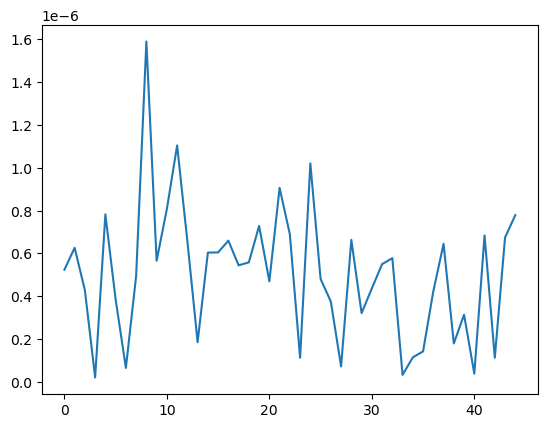

In [240]:
plt.plot(torch.sqrt(params_all[a]["bias_ps"].sum(dim=1)**2))

In [175]:
a = pseudocount_all.argsort()[-1]

n = 1
X = logps_x[a][n]
Y = logps_y[a][n]

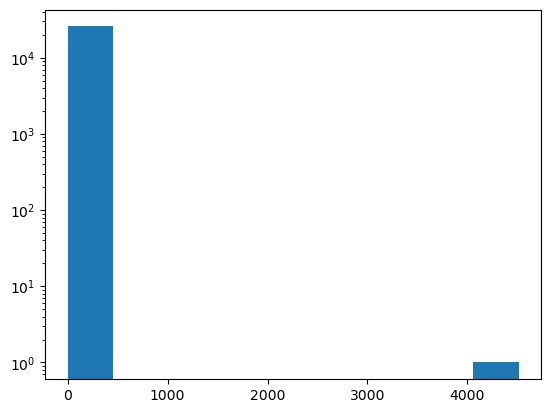

In [198]:
t = 2

id = (X[t] > 15) * (Y[t] > 15)
plt.hist(counts_others[n][t][id])
plt.yscale('log')

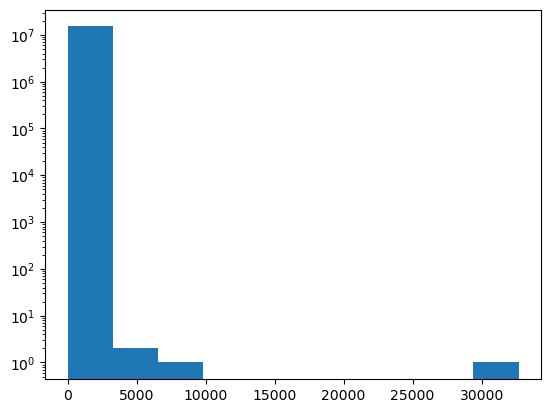

In [199]:
plt.hist(counts_others[n][t])
plt.yscale('log')